## Introduction

This notebook demostrates the results presented in:

Diego L. Guarin, Babak Taati, Andrea Bandini, Tessa Hadlock and Yana Yunusova, “Improving Automatic Orofacial Assessment”

In this notebook we will use the FAN model to find facial landmarks in an example image. We will compare the results of three different model:
- Original FAN
- FAN fine-tuned with 40 patients
- FAN fine-tuned with 160 patients 

To use this notebook you need the following Python libraries:
- Pytorch
- OpenCV
- Matplotlib
- Numpy 
- Pandas

In [14]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd


from face_alignment.utils import *
from face_alignment import api as face_alignment
from face_alignment.models import FAN
from face_alignment.detection.sfd import sfd_detector

Read image using opencv  || Here you can use your own image 

In [7]:
image = cv2.imread('./example/179 - 1136770_5.jpg')

Read ground truth landmark position 

If this information is not available then skip the following cell 

You can use our tool Emotrics (https://github.com/dguari1/Emotrics/tree/master/Tutorial) to determine the true landmark positions. Here the landmark position is provided as a .csv file (see ./example/179 - 1136770_5.csv). If you use Emotrics, then you need to transfer the output from that software to a .csv file. I provide a version of this solution in the notebook __From_Emotrics_to_csv__

In [22]:
image_information = pd.read_csv('./example/179 - 1136770_5.csv')
landmarks = image_information.iloc[0].values[6:]
target_landmarks = landmarks.astype('float').reshape(-1, 2)

Now we need to load the FAN model. We will also load a model to localize the face in an image. 

Fist we will load the weight provided by the authors, afterwards we will load the two models developed on the paper

In [65]:
#Utilities 
def load_weights(model, filename):
    #load weights from a file to a model
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

In [74]:

face_alignment_model = r"./models/2DFAN4-11f355bf06.pth.tar"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #if gpu is available then use it, otherwise, use cpu

#Face alignement Network 
network_size = 4
face_alignment_net = FAN(network_size)
load_weights(face_alignment_net,face_alignment_model)
face_alignment_net.to(device)
face_alignment_net.eval()

#face detection Network
face_detector_model = r"./models/s3fd-619a316812.pth"
face_detection_net = sfd_detector.SFDDetector(device=device, path_to_detector=face_detector_model, verbose=False)

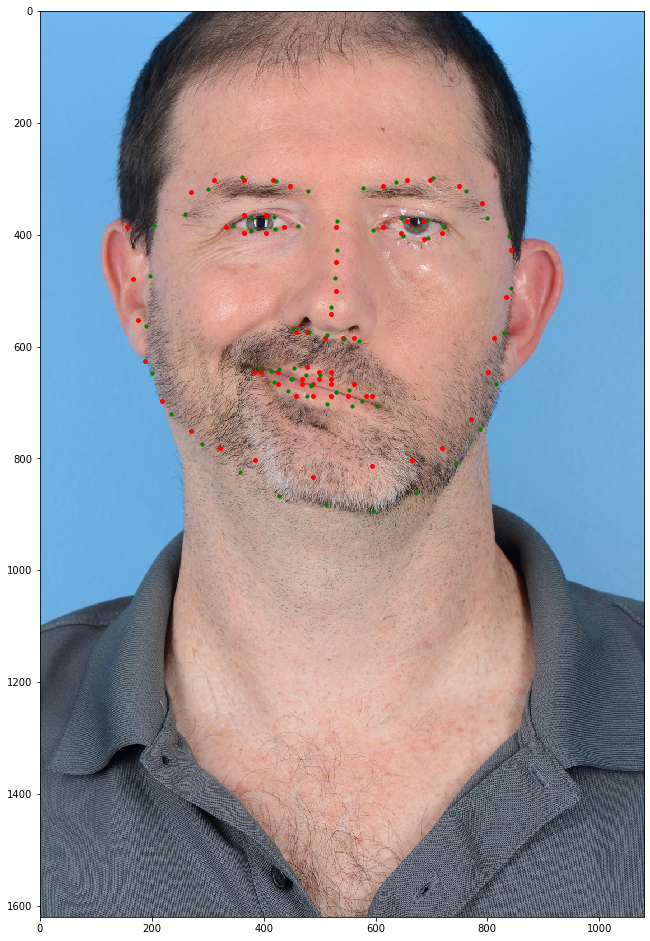

In [79]:
#First step is to find the face in the image --  for that, we use the face_detection network 
detected_faces = face_detection_net.detect_from_image(image)
for i, d in enumerate(detected_faces):
    center = torch.FloatTensor(
        [d[2] - (d[2] - d[0]) / 2.0, d[3] - (d[3] - d[1]) / 2.0])
    center[1] = center[1] - (d[3] - d[1]) * 0.12
    scale = (d[2] - d[0] + d[3] - d[1]) / face_detection_net.reference_scale
        
#the next step is to localize the facial landamrks --  for that, we use the face_aligment network
inp = crop(image, center, scale)
inp = torch.from_numpy(inp.transpose((2, 0, 1))).float()
inp = inp.to(device)
inp.div_(255).unsqueeze_(0)

out = face_alignment_net(inp)[-1].detach() #[-1] is to get the output of the last hourglass block
out = out.cpu()
pts, pts_img = get_preds_fromhm(out, center, scale)

pts_img = pts_img.view(68, 2)
landmarks  = pts_img.double().numpy()


#visualize
fig, ax1 = plt.subplots(figsize=(25,16.667))
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.scatter(landmarks[:,0],landmarks[:,1], s=15, c = 'r')

#if ground truth landmark positions are note available, remove the following lines
ax1.scatter(target_landmarks[:,0],target_landmarks[:,1], s=10, c='g')


Now we load new weights to the FAN model, here we try the model fine-tuned with 40 patients 

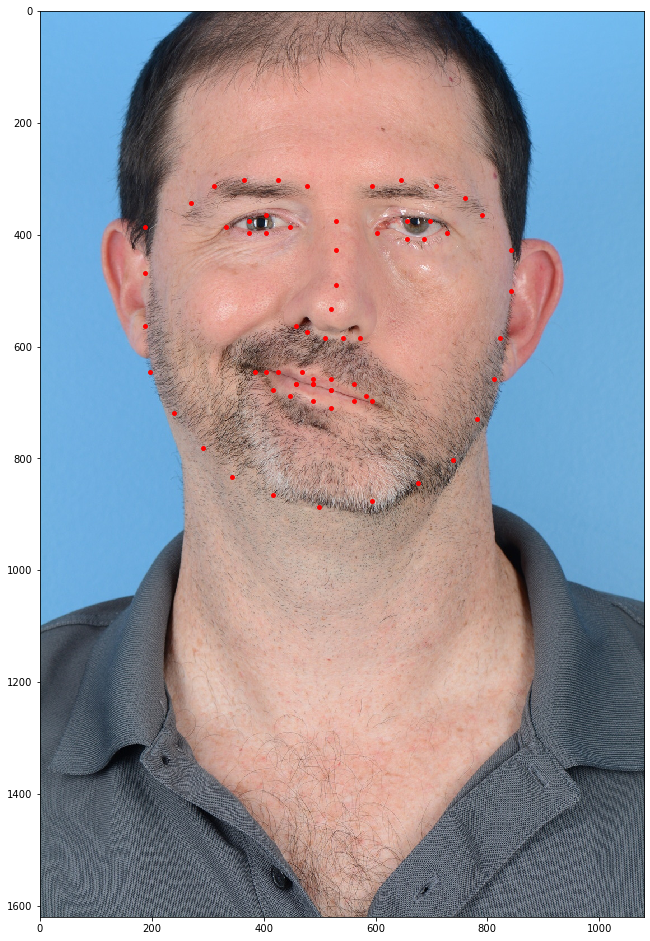

In [80]:
face_alignment_model = r"./models/2DFAN4-train40.pth.tar"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #if gpu is available then use it, otherwise, use cpu

#Face alignement Network 
network_size = 4
face_alignment_net = FAN(network_size)
load_weights(face_alignment_net,face_alignment_model)
face_alignment_net.to(device)
face_alignment_net.eval()

out = face_alignment_net(inp)[-1].detach() #[-1] is to get the output of the last hourglass block
out = out.cpu()
pts, pts_img = get_preds_fromhm(out, center, scale)

pts_img = pts_img.view(68, 2)
landmarks  = pts_img.double().numpy()


#visualize
fig, ax1 = plt.subplots(figsize=(25,16.667))
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.scatter(landmarks[:,0],landmarks[:,1], s=15, c = 'r')

#if ground truth landmark positions are note available, remove the following lines
ax1.scatter(target_landmarks[:,0],target_landmarks[:,1], s=10, c='g')

Finally, we load new weights to the FAN model, here we try the model fine-tuned with 160 patients 

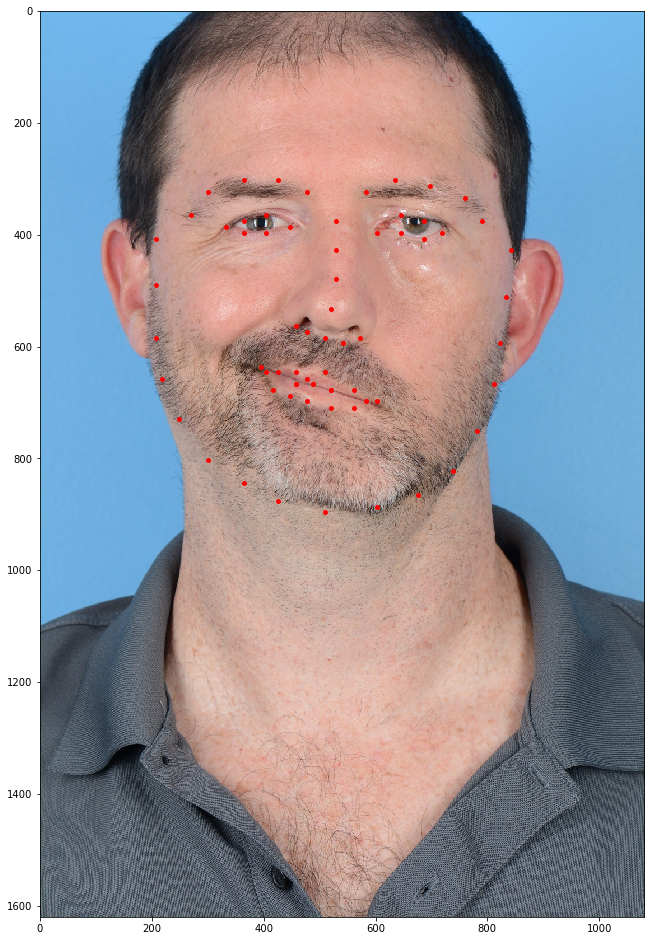

In [83]:
face_alignment_model = r"./models/2DFAN4-train160.pth.tar"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #if gpu is available then use it, otherwise, use cpu

#Face alignement Network 
network_size = 4
face_alignment_net = FAN(network_size)
load_weights(face_alignment_net,face_alignment_model)
face_alignment_net.to(device)
face_alignment_net.eval()

out = face_alignment_net(inp)[-1].detach() #[-1] is to get the output of the last hourglass block
out = out.cpu()
pts, pts_img = get_preds_fromhm(out, center, scale)

pts_img = pts_img.view(68, 2)
landmarks  = pts_img.double().numpy()


#visualize
fig, ax1 = plt.subplots(figsize=(25,16.667))
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.scatter(landmarks[:,0],landmarks[:,1], s=15, c = 'r')

#if ground truth landmark positions are note available, remove the following lines
ax1.scatter(target_landmarks[:,0],target_landmarks[:,1], s=10, c='g')

# FIN